### Team:
  > Amira Mo'men

  > Ibrahim Ayman 

### Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

### Importing Libraries

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == True:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

### Project helper Functions


In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    cv2.putText(img,"pitch: "+str(pitch)  , (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),2)
    cv2.putText(img,"yaw: "+str(yaw)  , (5, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),2)
    cv2.putText(img,"roll: "+str(roll)  , (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),2)
    return img

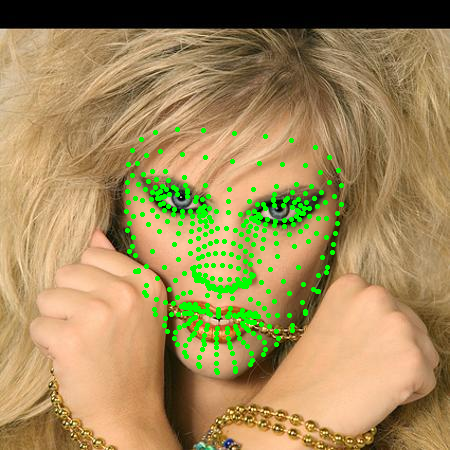

In [ ]:
file = 'image00002'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

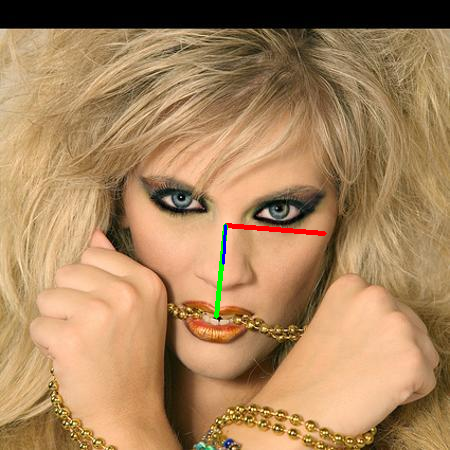

In [ ]:
image = cv2.imread('/content/AFLW2000/'+file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

### Data preparation
 

In [ ]:
def collect_points():
  X = []
  Y = []
  labels = []
  for file in os.listdir("/content/AFLW2000/"):
    if file.endswith('.jpg'):
      faceModule = mediapipe.solutions.face_mesh
      # loading image and its correspinding mat file
      with faceModule.FaceMesh(static_image_mode=True) as faces:
          # loading the image
          image = cv2.imread('/content/AFLW2000/'+ file)
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            mat_file = sio.loadmat('/content/AFLW2000/'+file[:-4] +'.mat')
            pose_para = mat_file["Pose_Para"][0][:3]
            x_,y_ = [],[]
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    x_.append(relative_x)
                    y_.append(relative_y)
                labels.append(pose_para)
                X.append(x_)
                Y.append(y_)  
                    # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
  X = np.array(X)
  Y = np.array(Y)
  labels = np.array(labels)
  features = np.hstack((X,Y))
  return features,labels

In [ ]:
features,labels=collect_points()


In [ ]:
features.shape

(1853, 936)

In [ ]:
columns_name = np.array([['x' + str(i),'y' + str(i)] for i in range(len(features[1])//2)]).reshape(1,-1)[0].tolist()
df =pd.DataFrame(features,columns = columns_name)

In [ ]:
df.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,229,225,226,214,224,223,219,153,216,215,...,279,276,278,281,282,212,216,219,200,196
1,234,234,233,226,234,233,230,176,229,229,...,255,252,264,254,258,229,230,229,232,228
2,212,208,213,206,207,209,216,175,218,218,...,266,263,270,266,268,226,228,229,223,218
3,224,230,227,225,232,233,235,167,237,239,...,276,273,280,277,278,220,221,222,221,220
4,206,187,205,192,186,190,206,192,209,207,...,277,274,278,278,280,216,220,223,208,201


### Scaling data

In [ ]:
dist = np.sqrt( (df["x152"] - df["x10"])**2 + (df["y152"] - df["y10"])**2 )
dist

0       130.080744
1       109.895405
2        71.554175
3       116.417353
4        51.429563
           ...    
1848    161.993827
1849    118.532696
1850     41.880783
1851    122.065556
1852    146.109548
Length: 1853, dtype: float64

In [ ]:
df_Scale=df
df_Scale.iloc[:, 0::2]=df_Scale.iloc[:, 0::2].sub(df_Scale['x1'], axis=0)
df_Scale

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,3,225,0,214,-2,223,-7,153,-10,215,...,53,276,52,281,56,212,-10,219,-26,196
1,1,234,0,226,1,233,-3,176,-4,229,...,22,252,31,254,25,229,-3,229,-1,228
2,-1,208,0,206,-6,209,3,175,5,218,...,53,263,57,266,55,226,15,229,10,218
3,-3,230,0,225,5,233,8,167,10,239,...,49,273,53,277,51,220,-6,222,-6,220
4,1,187,0,192,-19,190,1,192,4,207,...,72,274,73,278,75,216,15,223,3,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,6,245,0,224,2,237,-21,150,-30,208,...,26,262,24,268,29,214,-24,219,-47,191
1849,2,210,0,205,-6,211,2,156,3,218,...,67,279,65,283,69,218,5,222,-4,208
1850,4,188,0,187,-18,186,-10,190,-12,187,...,55,254,50,259,57,215,16,221,-6,191
1851,0,227,0,218,-2,226,-3,160,-3,224,...,54,279,54,283,56,220,-6,224,-17,207


In [ ]:
df_Scale.iloc[:, 1::2]=df_Scale.iloc[:, 1::2].sub(df_Scale['y1'], axis=0)
df_Scale

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,3,11,0,0,-2,9,-7,-61,-10,1,...,53,62,52,67,56,-2,-10,5,-26,-18
1,1,8,0,0,1,7,-3,-50,-4,3,...,22,26,31,28,25,3,-3,3,-1,2
2,-1,2,0,0,-6,3,3,-31,5,12,...,53,57,57,60,55,20,15,23,10,12
3,-3,5,0,0,5,8,8,-58,10,14,...,49,48,53,52,51,-5,-6,-3,-6,-5
4,1,-5,0,0,-19,-2,1,0,4,15,...,72,82,73,86,75,24,15,31,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,6,21,0,0,2,13,-21,-74,-30,-16,...,26,38,24,44,29,-10,-24,-5,-47,-33
1849,2,5,0,0,-6,6,2,-49,3,13,...,67,74,65,78,69,13,5,17,-4,3
1850,4,1,0,0,-18,-1,-10,3,-12,0,...,55,67,50,72,57,28,16,34,-6,4
1851,0,9,0,0,-2,8,-3,-58,-3,6,...,54,61,54,65,56,2,-6,6,-17,-11


In [ ]:
df_Scale=df_Scale.div(dist,axis=0)
df_Scale.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,0.023063,0.084563,0.0,0.0,-0.015375,0.069188,-0.053813,-0.468940,-0.076875,0.007688,...,0.407439,0.476627,0.399752,0.515065,0.430502,-0.015375,-0.076875,0.038438,-0.199876,-0.138376
1,0.009100,0.072796,0.0,0.0,0.009100,0.063697,-0.027299,-0.454978,-0.036398,0.027299,...,0.200190,0.236589,0.282086,0.254788,0.227489,0.027299,-0.027299,0.027299,-0.009100,0.018199
2,-0.013975,0.027951,0.0,0.0,-0.083853,0.041926,0.041926,-0.433238,0.069877,0.167705,...,0.740698,0.796599,0.796599,0.838525,0.768648,0.279508,0.209631,0.321435,0.139754,0.167705
3,-0.025769,0.042949,0.0,0.0,0.042949,0.068718,0.068718,-0.498208,0.085898,0.120257,...,0.420899,0.412310,0.455259,0.446669,0.438079,-0.042949,-0.051539,-0.025769,-0.051539,-0.042949
4,0.019444,-0.097220,0.0,0.0,-0.369437,-0.038888,0.019444,0.000000,0.077776,0.291661,...,1.399973,1.594414,1.419417,1.672190,1.458305,0.466658,0.291661,0.602766,0.058332,0.174997


In [ ]:
df.to_csv('data.csv')
df_Scale.to_csv('data_scale.csv')

In [ ]:
df_labels=pd.DataFrame(labels,columns=["pitch","yaw","roll"])
df_labels

,pitch,yaw,roll
0,-0.287115,-0.029494,-0.130066
1,0.404001,-0.131908,-0.084306
2,-0.065386,0.396279,-0.040050
3,0.009365,-0.110966,0.145353
4,-0.077208,0.809039,-0.160356
...,...,...,...
1848,-0.102369,-0.344018,-0.322496
1849,-0.074399,0.167313,0.016875
1850,-0.065808,1.086726,-0.757008
1851,-0.188409,0.017142,-0.010053


In [ ]:
df_labels.to_csv('labels.csv')

###Training Model

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(df_Scale,df_labels,test_size=0.2,train_size=0.8)
labels_train.head()

,pitch,yaw,roll
1019,-0.242976,-0.186844,-0.607182
1208,-0.618758,-1.171226,0.711355
1763,-0.499132,0.864486,-0.299956
1690,-0.049385,0.844046,-0.176926
516,-0.074684,0.045188,0.437950


In [ ]:
features_train.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
1019,0.058200,0.142267,0.0,0.0,-0.071134,0.071134,-0.213401,-0.400936,-0.303935,-0.174601,...,0.232801,0.381536,0.168134,0.426802,0.252201,0.051734,-0.097001,0.103467,-0.316868,-0.174601
1208,-0.010479,0.073356,0.0,0.0,0.230547,0.083835,0.104794,-0.544928,0.125753,0.041918,...,0.482052,0.335341,0.492532,0.377258,0.503011,-0.178150,-0.020959,-0.125753,-0.062876,-0.220067
1763,0.000000,-0.194602,0.0,0.0,-0.510829,-0.121626,0.097301,0.243252,0.243252,0.486504,...,1.873041,2.091968,1.946017,2.140619,1.921692,0.754082,0.559480,0.875708,0.608130,0.754082
1690,0.032889,0.000000,0.0,0.0,-0.279554,0.000000,-0.049333,-0.164443,-0.032889,0.147999,...,1.134660,1.315547,1.151104,1.381325,1.183993,0.328887,0.164443,0.443997,-0.082222,0.065777
516,-0.124939,-0.093704,0.0,0.0,0.109322,0.046852,0.374817,-0.640312,0.530991,0.452904,...,0.983895,0.827721,1.093216,0.843338,1.015129,0.109322,0.265495,0.124939,0.437287,0.281113


## Train Some modles without tunnig


#### SVR

In [ ]:
#pitch_model
pitch_model = SVR()
pitch_model.fit(features_train,labels_train["pitch"])
mean_squared_error(pitch_model.predict(features_validation_test),labels_validation_test["pitch"])

0.02898123745535573

In [ ]:
#yaw model
yaw_model = SVR()
yaw_model.fit(features_train,labels_train["yaw"])
mean_squared_error(yaw_model.predict(features_validation_test),labels_validation_test["yaw"])

0.022839596510364844

In [ ]:
yaw_model.score(features_validation_test,labels_validation_test["yaw"])

0.9192134081227792

In [ ]:
#roll model
roll_model = SVR()
roll_model.fit(features_train,labels_train["roll"])
mean_squared_error(roll_model.predict(features_validation_test),labels_validation_test["roll"])

0.016190622610160344

### XGBRegressor

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(XGBRegressor(verbosity=0))
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.22679903598113638

### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
model = MultiOutputRegressor(RandomForestRegressor())
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.13564202396380384

### GradientBoostingRegressor

In [ ]:
model = MultiOutputRegressor(GradientBoostingRegressor())
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.16151307826525854

> We used SVR because it was the lest mean squuer error without any tunning

### tuning SVR hyper parameters with GridSearch


In [ ]:
parameters = {'kernel': ['rbf','poly','sigmoid'],
                  'C': [0.01, 0.1, 1 , 10, 100,200,300],
                  'gamma': ['scale',1,.1],
                  'epsilon':[0.01,0.1,0.5,0.3],
                  
                }

model=SVR()

In [ ]:
pitch = GridSearchCV(estimator = model,param_grid = parameters)
pitch.fit(features_train,labels_train["pitch"])
pitch_model2 =pitch.best_estimator_
mean_squared_error(pitch_model2.predict(features_validation_test),labels_validation_test["pitch"])

0.046051199398923166

In [ ]:
yaw = GridSearchCV(estimator = model,param_grid = parameters)
yaw.fit(features_train,labels_train["yaw"])
yaw_model2 =yaw.best_estimator_
mean_squared_error(yaw_model2.predict(features_validation_test),labels_validation_test["yaw"])

0.022839596510364844

In [ ]:
roll = GridSearchCV(estimator = model,param_grid = parameters)
roll.fit(features_train,labels_train["roll"])
roll_model2 = roll.best_estimator_
mean_squared_error(roll_model2.predict(features_validation_test),labels_validation_test["roll"])

0.016190622610160344

In [ ]:
import pickle
pickle.dump(pitch_model2, open("pitch_model2.svr", 'wb'))
pickle.dump(yaw_model2, open("yaw_model2.svr", 'wb'))
pickle.dump(roll_model2, open("roll_model2.svr", 'wb'))

In [ ]:
pitch_model2 = pickle.load(open("pitch_model2.svr", 'rb'))
yaw_model2 = pickle.load(open("yaw_model2.svr", 'rb'))
roll_model2 = pickle.load(open("roll_model2.svr", 'rb'))

In [ ]:
def get_point(path): 
  
  x_points=[]
  y_points=[]
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread(path)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        
        for face in results.multi_face_landmarks:
            i=0
            print("--------------------------------------")
            for landmark in face.landmark:
                i+=1
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                x_points.append(relative_x)
                y_points.append(relative_y)
        cv2_imshow(image)
      else:
        print("couldnt detect!")
  center_x=x_points[1]
  center_y=y_points[1]      
  dist = np.sqrt( (x_points[152] - x_points[10])**2 + (y_points[152] - y_points[10])**2 )
  x_points = np.array([x - x_points[1] for x in x_points])
  y_points = np.array([y - y_points[1] for y in y_points])
  points=np.hstack((x_points,y_points))
  points=points/dist
  return(points.reshape(1,-1),center_x,center_y)        
    

In [ ]:
def draw_img(path, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (sin(yaw)) + tdx
    y1 = size * (-cos(yaw) * sin(pitch)) + tdy
    
    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (cos(yaw) * cos(roll)) + tdx
    y3 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

--------------------------------------


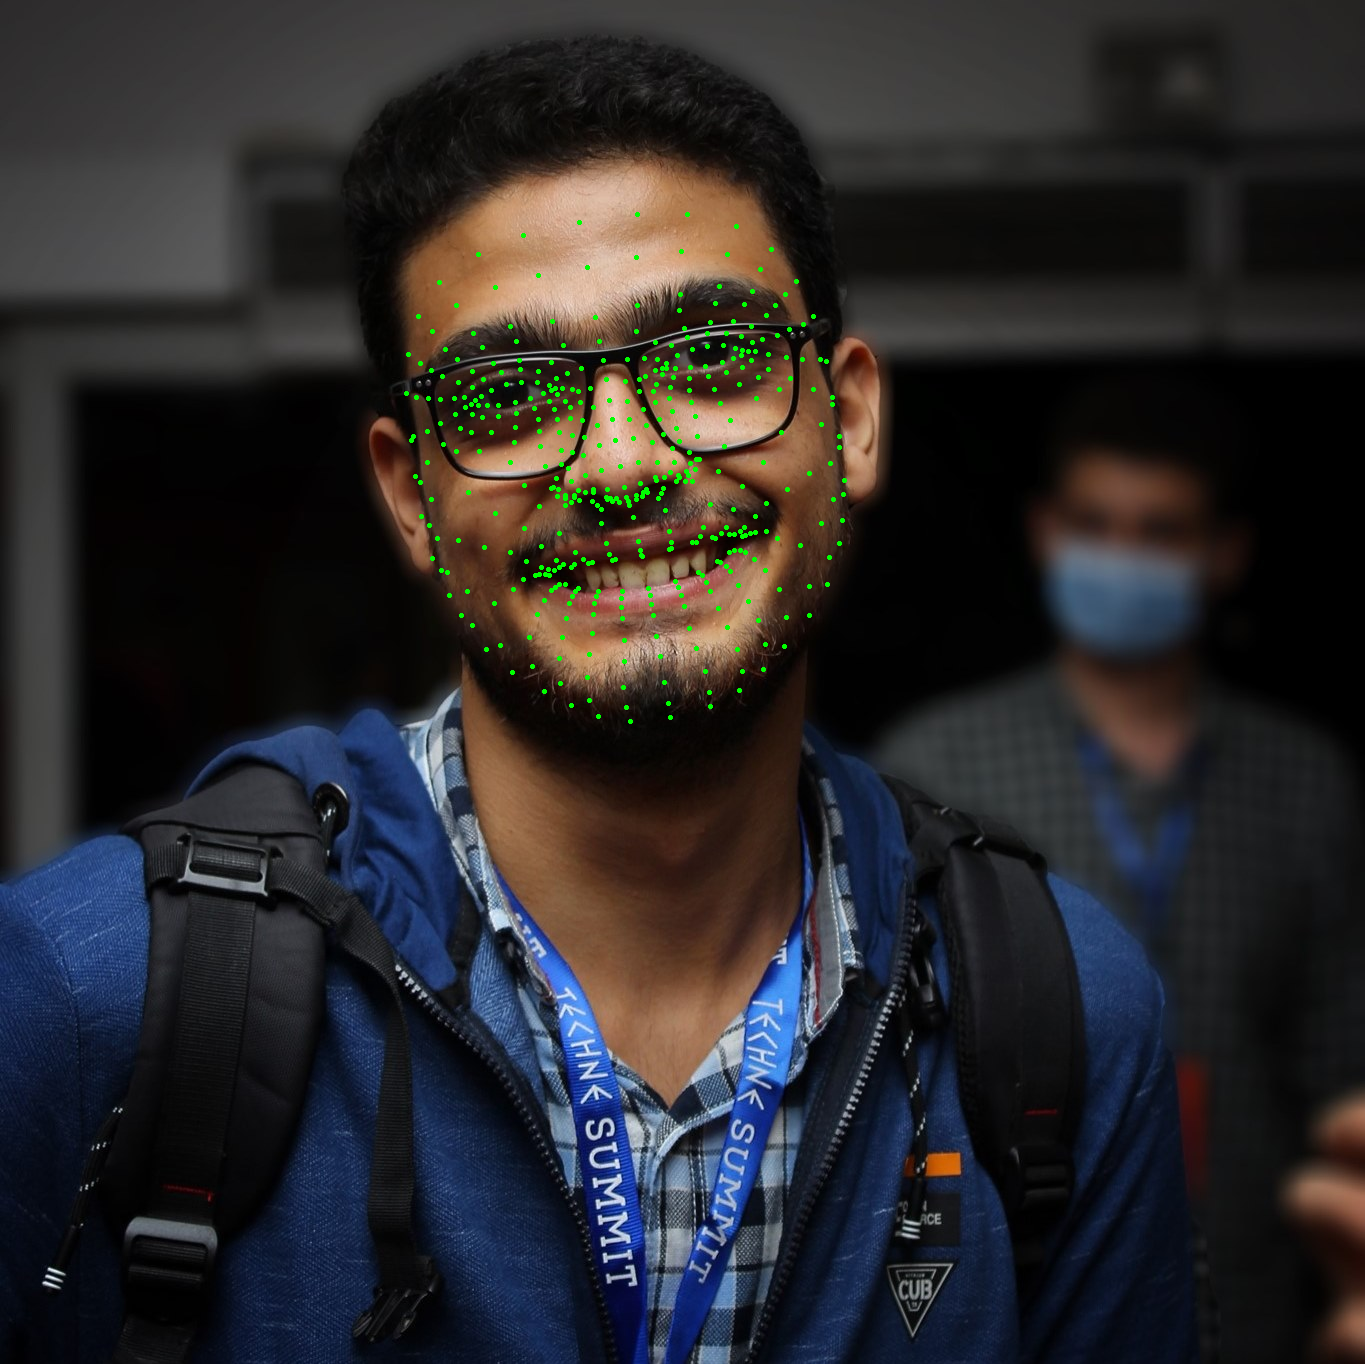

In [ ]:
path="/content/ibrahimmmm.jpg"
points,center_x,center_y=get_point(path)

In [ ]:
pitch=pitch_model2.predict(points)
yaw=yaw_model2.predict(points)
roll=roll_model2.predict(points)

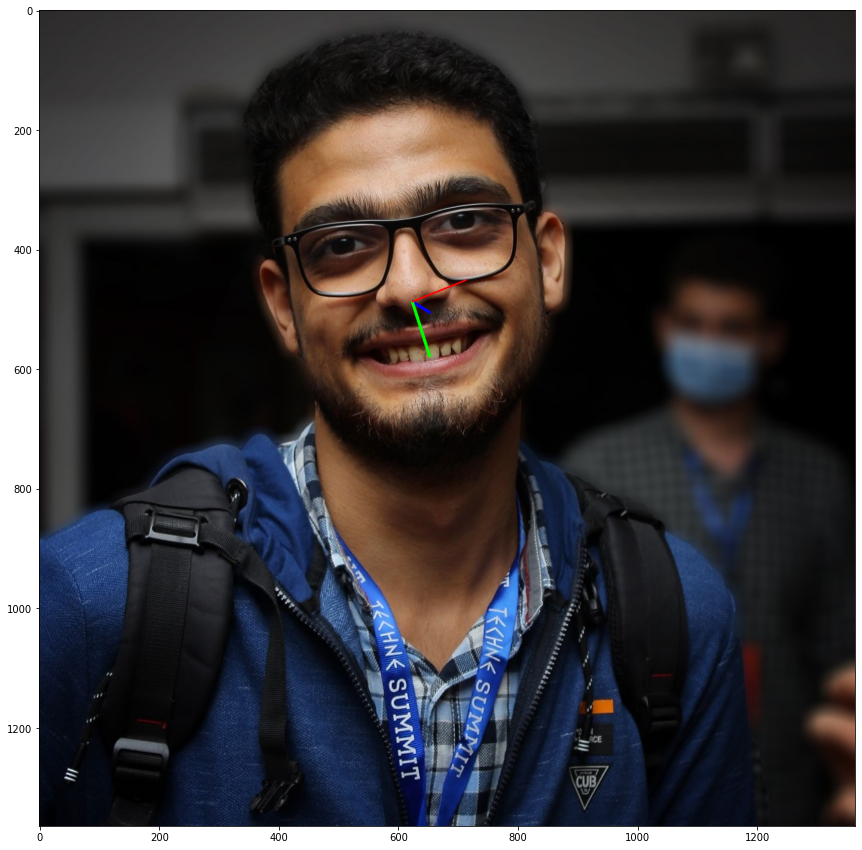

In [ ]:
import  matplotlib.pyplot as plt
img=draw_img(path, pitch,yaw,roll, tdx=center_x, tdy=center_y, size = 100)
plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.show()

###videos 


In [ ]:
def get_frame_point(image): 
  
  x_points=[]
  y_points=[]
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        
        for face in results.multi_face_landmarks:
            i=0
            for landmark in face.landmark:
                i+=1
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                x_points.append(relative_x)
                y_points.append(relative_y)
  center_x=x_points[1]
  center_y=y_points[1]      
  dist = np.sqrt( (x_points[152] - x_points[10])**2 + (y_points[152] - y_points[10])**2 )
  x_points = np.array([x - x_points[1] for x in x_points])
  y_points = np.array([y - y_points[1] for y in y_points])
  points=np.hstack((x_points,y_points))
  points=points/dist
  return(points.reshape(1,-1),center_x,center_y)        
    

In [ ]:
def predict_frame(image,pitch_model,yaw_model,roll_model):
  face ,center_X,center_y = get_frame_point(image)
  shape = image.shape
  yaw = yaw_model.predict(face)
  pitch = pitch_model.predict(face)
  roll = roll_model.predict(face)
  image = draw_axis(image,pitch,yaw,roll,tdx=center_X, tdy=center_y, size = 100)
  return image

In [ ]:
import cv2
video_path = "aaaddd.mp4"
video = cv2.VideoCapture(video_path)
width= int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames = []
while True:
    ret, frame = video.read()
    frame=cv2.rotate(frame, cv2.ROTATE_180)
    if not ret:
        break
    pred = predict_frame(frame,pitch_model2,yaw_model2,roll_model2)
    if pred.shape != np.array([-1]).shape:
      frames.append(pred)
video.release()


In [ ]:
out = cv2.VideoWriter('last.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for frame in frames:
    out.write(frame)
out.release()

In [ ]:
x= np.array([1,2,3])
str(type(x))

"<class 'numpy.ndarray'>"